# Property insurance risk assessment: 
using public data to estimate building features that affect insurance value


In [150]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


### Define the constant

In [151]:
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Pair the image label

<AxesSubplot: >

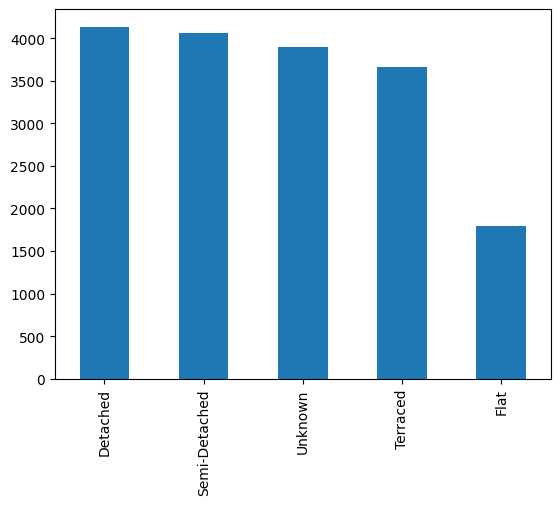

In [152]:
# loading the file name of the image
# filenames = os.listdir("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view")
filenames = os.listdir("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example")
pro = pd.read_csv("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/properties.csv")
pro['property_id'] = 'gsv_' + pro['property_id'] + '.jpg'
pro['propertyType'].value_counts().plot.bar()

In [153]:
pro.shape[0]


17550

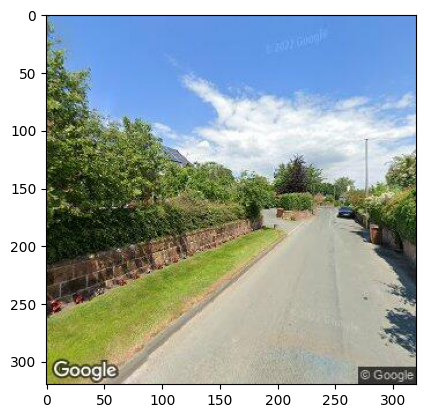

In [154]:
sample = random.choice(filenames)
image = load_img("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/"+sample)
plt.imshow(image)

### Spliting the train and test set

In [155]:
train, test = train_test_split(pro, test_size=0.20, random_state=33)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [156]:
train.head()

,Unnamed: 0,address,propertyType,bedrooms,detailUrl,location_lat,location_lng,property_id
0,0,"Weald Barn House, Wierton Hill, Boughton Monch...",Semi-Detached,4.0,https://www.rightmove.co.uk/house-prices/detai...,51.21990,0.54807,gsv_6f9797e6-917c-428e-a3cb-5a12fa7736b3.jpg
1,0,"Braeside, Langlee, Jedburgh, Roxburghshire TD8...",Unknown,NaN,https://www.rightmove.co.uk/house-prices/detai...,55.45179,-2.56030,gsv_31139028-3fe2-4526-8f7d-40be5d1dc352.jpg
2,0,"40, Noel Gate, Aughton, Ormskirk, Lancashire L...",Semi-Detached,2.0,https://www.rightmove.co.uk/house-prices/detai...,53.55175,-2.91041,gsv_d6b07a47-7c1a-49bb-93ab-be6ac539bb94.jpg
3,0,"42, Windsor Road, Levenshulme, Manchester, Gre...",Semi-Detached,5.0,https://www.rightmove.co.uk/house-prices/detai...,53.44540,-2.19629,gsv_42d66d7e-e5aa-4baf-957f-20339589be28.jpg
4,0,"3, Maesyllan, Llansilin, Oswestry, Powys SY10 7QE",Semi-Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,52.84316,-3.17405,gsv_f8884edb-6cea-400a-94b7-5d4e14e1eeef.jpg


<AxesSubplot: >

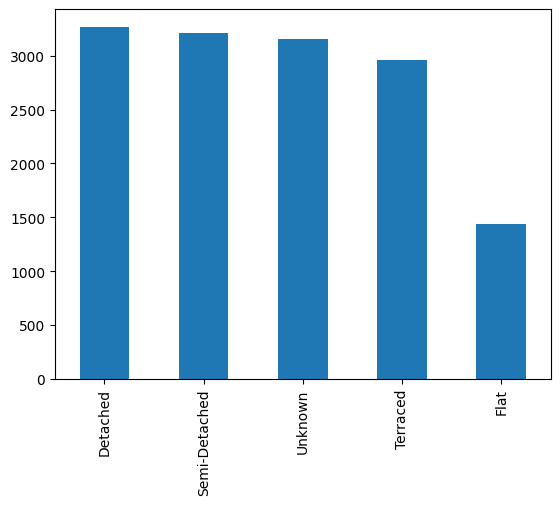

In [157]:
train['propertyType'].value_counts().plot.bar()

<AxesSubplot: >

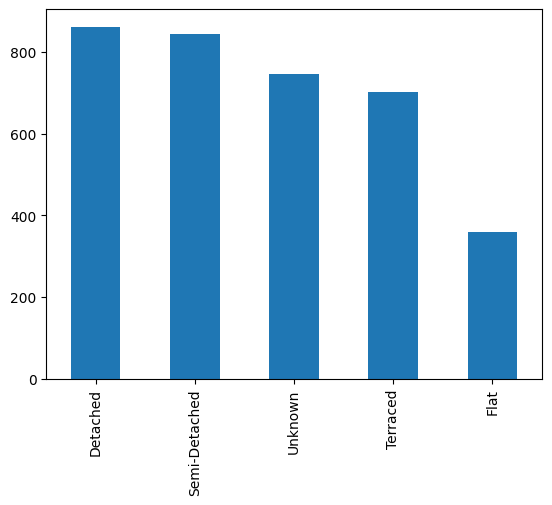

In [158]:
test['propertyType'].value_counts().plot.bar()

In [159]:
train_num = train.shape[0]
test_num = test.shape[0]
# In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples. You may see these values used in models in the literature and in tutorials.
# batch_size=64
batch_size=64
# The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized. You may see examples of the number of epochs in the literature and in tutorials set to 10, 100, 500, 1000, and larger.
# epochs=100
epochs=50

### Building CNN model

In [160]:
model = Sequential()

# Convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 159, 159, 32)     0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 159, 159, 32)      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 78, 78, 64)       0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 78, 78, 64)       

### Prevent over-fitting: callback

In [161]:
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

earlystop = EarlyStopping(patience=10)

In [162]:
# We will reduce the learning rate when then accuracy not increase for 3 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.0001)

In [163]:
callbacks = [earlystop, learning_rate_reduction]
# callbacks = [earlystop]

### Image generator

In [164]:
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_imagegenerator = train_idg.flow_from_dataframe(
    train, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2034 validated image filenames belonging to 5 classes.


In [165]:
test_idg = ImageDataGenerator(rescale=1./255)
test_imagegenerator = test_idg.flow_from_dataframe(
    test, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 516 validated image filenames belonging to 5 classes.


In [166]:
# # example: 

# example_df = train.sample(n=1).reset_index(drop=True)
# example_generator = train_idg.flow_from_dataframe(
#     example_df, 
#     "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
#     x_col='property_id',
#     y_col='propertyType',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical'
# )

In [167]:
# plt.figure(figsize=(12, 12))
# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

### Fit on the Training set and make predcitons on the Validation set

In [168]:

history = model.fit_generator(
    train_imagegenerator, 
    epochs=epochs,
    validation_data=test_imagegenerator,
    # validation_steps=test_num//batch_size,
    # steps_per_epoch=train_num//batch_size,
    callbacks=callbacks
)




Epoch 1/50
32/32 [==============================] - 156s 5s/step - loss: 2.7506 - accuracy: 0.2271 - val_loss: 1.5525 - val_accuracy: 0.2539 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 142s 4s/step - loss: 1.5452 - accuracy: 0.2616 - val_loss: 1.4791 - val_accuracy: 0.3314 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 143s 4s/step - loss: 1.4829 - accuracy: 0.3166 - val_loss: 1.4216 - val_accuracy: 0.3702 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 148s 5s/step - loss: 1.4159 - accuracy: 0.3727 - val_loss: 1.3779 - val_accuracy: 0.3837 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 147s 5s/step - loss: 1.3836 - accuracy: 0.3923 - val_loss: 1.4339 - val_accuracy: 0.3798 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 150s 5s/step - loss: 1.3609 - accuracy: 0.4208 - val_loss: 1.3866 - val_accuracy: 0.3702 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 148s 5s/step - loss: 1.3

### Visualize the result

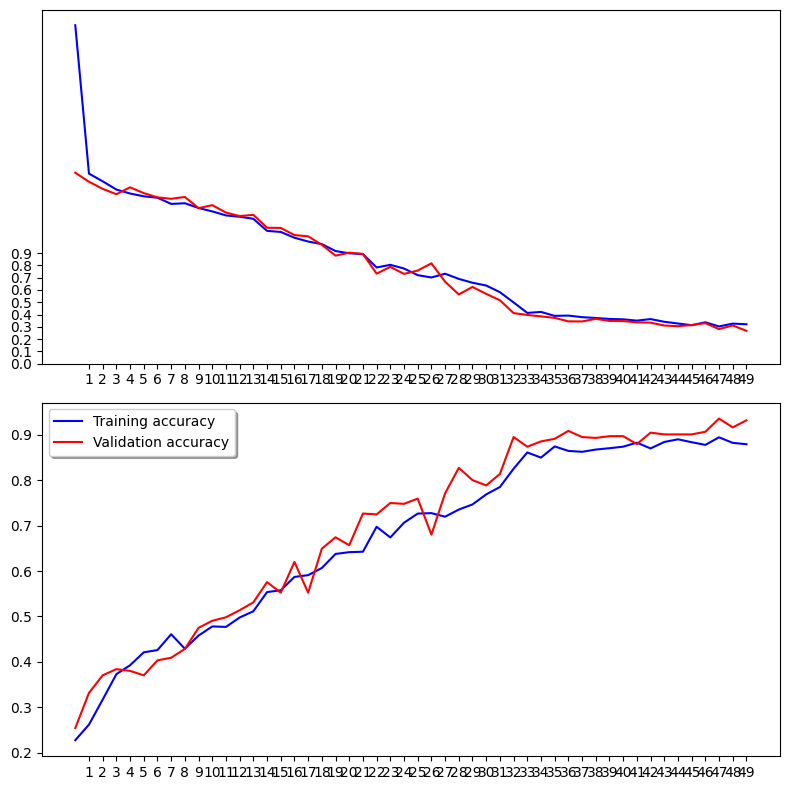

In [171]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()